# Defining a Potential

We use a class based approach to defining our potentials.

Theres a base class called JaxDensity where all of the numerical methods are defined.
Specific subclasses corresponding to known models (e.g Plummer NFW) are defined for each model in models.py

You can look at {doc}`./tutorial_potential` for some examples of the built-in models.

For those models, whenever analytical espressions for dynamical quantities are known the numerical methods are overridden with the analytical methods, otherwise the numerical methods are used.

For testing purposes it may be useful to compare the numerical methods to the analytic expressions to ensure that the numerical methods are working correctly.

Below we show the minimum code needed to define a custom model and compare the numerical methods to the analytical expressions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dynamicAll.base import JaxDensity

The general idea is that if you want to implement a model that is not built in is that all you have to define is one or two functions and then everything else can be calculated numerically.

The more functions you specify will lead to slightly faster calculations and perhaps slighly more accurate results, but we show that even defining just one function you can achieve good results.

We'll start with the Plummer model as an example.

### A Good Test of our Numerical Methods

A particularly tricky function to calculate given just a density profile is the Distribution function. This is a function that gives the probability of finding a star in a particular phase space volume. It is defined as:

$$
f(\mathcal{E}) = \frac{1}{\sqrt{8}\pi^2} \frac{d}{d\mathcal{E}}\int_0^{\mathcal{E}}\frac{d\rho}{d\psi}\frac{d\psi}{\sqrt{\mathcal{E}-\psi}}
$$

The combination of integrals and derivatives can make this a difficult function to calculate so it'll be a good litmus test for our numerical methods.

Below we show how to define a mode which is just a Plummer model.We show that we can accurately calculate the distribution function using just the density profile.
The fact that the distribution function is a non-trivial function of the density profile and various other quantities means that if we can accurately calculate the distribution function then we can be confident that our numerical methods are working correctly.

In [14]:
from functools import partial
import jax
import jax.numpy as jnp


class Plummer_test(JaxDensity):
    """
    Pretending we don't know that most dynamical quantities for a self-consistent Plummer model are known analytically,
    We define just the density profile and compare the numerical methods to the analytical results.
    """

    def __init__(self, M: float, rs: float):
        """
        M: float
            Total mass of the Plummer model
        rs: float
            Scale radius of the Plummer model
        """
        self._M = M
        self._rs = rs
        self._params = {"M": self._M, "rs": self._rs}

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def _density(cls, r: float, params) -> float:
        """
        Analytical density profile of a Plummer model.

        Parameters
        ----------
        r : jnp.ndarray
            radius in units of [kpc]
        params : dict
            Dictionary containing the parameters of the Plummer model

        Returns
        -------
        float
            Density at radius r in units of [Msun / kpc^3]

        Notes
        -----
        When Defining profiles the analytica functions can accept either jnp.ndarray or float as input.
        However, when vectorizing using vmap or taking derivatives there might be unintended behavior if you decide to vmap every function.
        We therefore usually leave vectorization to the user.
        """
        q = r / params["rs"]
        coeff = 3 * params["M"] / (4 * jnp.pi * params["rs"] ** 3)

        return coeff * (1 + q**2) ** (-5 / 2)

Here we defined a plummer model using the density as a starting point. If we wanted a different starting point -i.e you have a specific parameterization in mind for the mass or potential - you can instead use JaxMass or JaxPotential as the starting point.

In that case all you need to define is _mass and _density and everything else can be done numerically.

You can start out with a Distribution function, but in that case you also need to specify the potential in the currrent  implementation. See the Docs and source code doc strings for more information.

```{note}
Although you only need one function to define a model, the more functions you can define analytically the better and faster the code will run. 
```

## Initialize your model


In [15]:
params = {"M": 3e5, "rs": 0.5}
plum_test = Plummer_test(**params)

```{note}
You don't have to initialize the class.
You can use it in a more functional form by using the class methods.

All that calling plum_test.density(r) does is call the class method _density(r,params).
In actual fitting where you're changing the parameters you would always want to use the class methods rather than the instance methods.

See the plot below showing the density profile we just defined being called in two different ways.
```

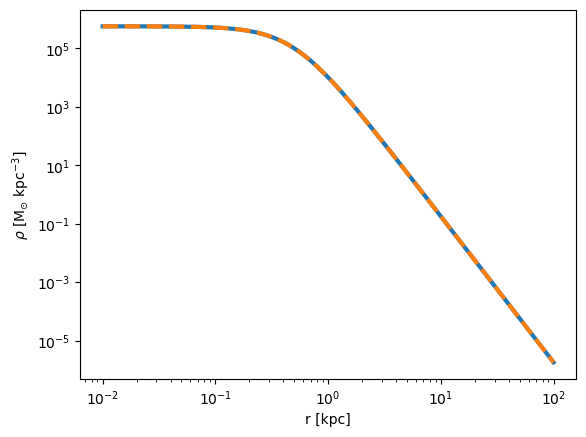

In [16]:
import matplotlib.pyplot as plt

r = jnp.logspace(-2, 2, 100)
fig, ax = plt.subplots()
lw = 3
## instance method
ax.plot(r, plum_test.density(r), lw=lw)
## class method
ax.plot(r, Plummer_test._density(r, params), linestyle="--", lw=lw)
ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [kpc]",
    ylabel=r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",
);

## Test against built-in Model
The built in Plummer model has almost all dynamical quantities defined analytically. We can compare the numerical methods to the analytical methods to see if they're working correctly.

In [17]:
from dynamicAll import models

plum = models.Plummer(**params)

The difference between our numerical methods and the analytical methods is less than 1e-6 for all quantities.

Our integration scheme is very simple, but we show that it is very accurate for a wide range of models.
see {doc}`./tutorial_potential` where we compare various models with analytical functions versus the equivalent Hernquist-Zhao model that uses analytical methods

[None, None, Text(0.5, 0, 'r'), Text(0, 0.5, '$\\Delta \\Phi$'), (1e-20, 0.01)]

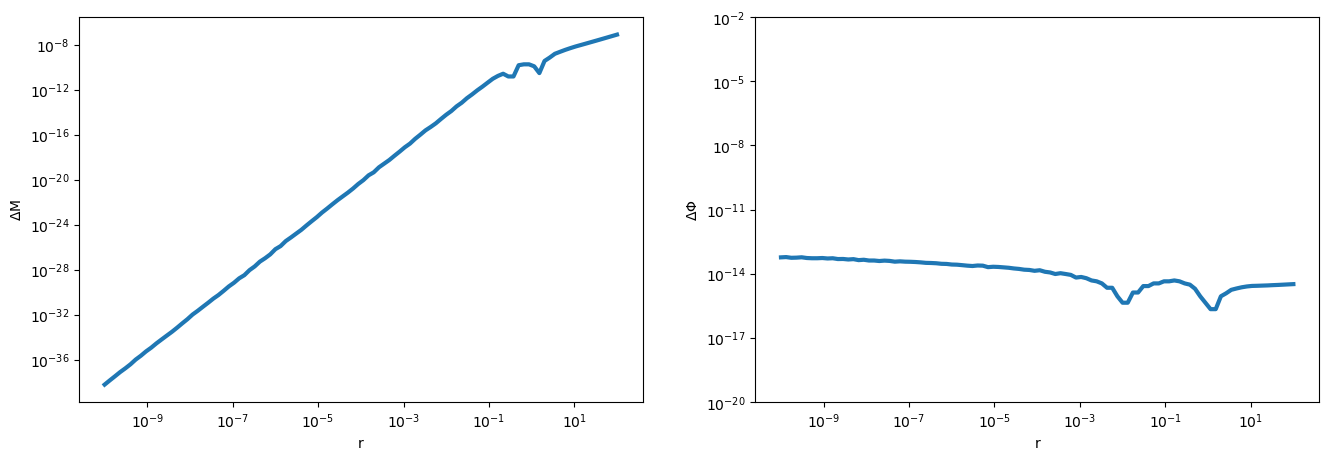

In [18]:
import matplotlib.pyplot as plt

vec_mass = jax.vmap(plum_test._mass, in_axes=(0, None))
# vec_mass2 = jax.vmap(plum_test.test_mass, in_axes=(0, None))
r = jnp.logspace(-10, 2, 100)
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
lw = 3
# plot difference between the two mass functions
ax[0].plot(r, jnp.abs(vec_mass(r, params) - plum.mass(r)), lw=lw)

ax[0].set(
    xscale="log",
    yscale="log",
    xlabel="r",
    ylabel=r"$\Delta$M",
    # ylim=(1e-20, 1e-10),
)
# plot difference in the potential
ax[1].plot(
    r,
    jnp.abs(
        jax.vmap(Plummer_test._potential, in_axes=(0, None))(r, params)
        - plum.potential(r)
    ),
    lw=lw,
)
ax[1].set(
    xscale="log",
    yscale="log",
    xlabel="r",
    ylabel=r"$\Delta \Phi$",
    ylim=(1e-20, 1e-2),
)

### The issue of vectorization with vmap

It could be seen as annoying to have to physically vectorize functions manually. Analytical functions are able to accept either float or array inputs, but most functions we define numericallly are only able to accept float inputs forcing us to vectorize them any time we want to use them in a vectorized context which is often.

This ultimately gives us more control over how we want to vectorize our functions. We can vectorize them over many radii, or vectorize them over many parameters, or both!

Both can be particularly powerful when attempting to explore the parameter space of a model.

Below we show a very simple example of of being able to vectorize over many parameters and many radii at the same time.


In [19]:
params_list = [{"M": 1.0, "rs": 1.0}, {"M": 1.0, "rs": 2.0}, {"M": 1.0, "rs": 3.0}]
params_dict = {k: jnp.array([p[k] for p in params_list]) for k in params_list[0]}

vmap_both = jax.vmap(
    jax.vmap(Plummer_test._mass, in_axes=(0, None)),
    in_axes=(None, 0),
)

In [20]:
test_vectorization = vmap_both(r, params_dict)

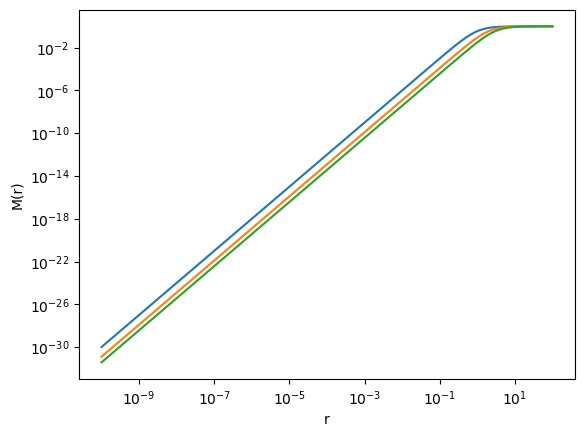

In [21]:
fig, ax = plt.subplots()
for mass in test_vectorization:
    ax.plot(r, mass)
ax.set(xscale="log", yscale="log", xlabel="r", ylabel="M(r)");

## Calculating the Distribution function

As stated above the distribution function is a particularly involved function to calculate numerically. Only having defined one function -- the density profile we test whether we can accurately calculate the distribution function.

Our Plummer model has a known distribution function so a very simple test is to compare our numerical calculation to the known analytical calculation.

In [22]:
mathcal_E = jnp.logspace(-3, jnp.log10(-0.99 * plum_test._potential(1e-9, params)), 200)

# mathcal_E is a bad name for the variable, but it is the latex symbol for the relative energy used in Binney & Tremaine

In [23]:
DF = plum_test.DistributionFunction(mathcal_E, params)

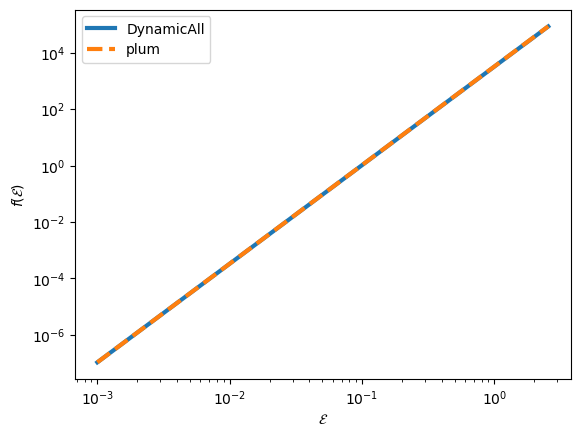

In [24]:
fig, ax = plt.subplots()

ax.plot(mathcal_E, DF, label="DynamicAll", linestyle="-", lw=3)
ax.plot(mathcal_E, plum.DF(mathcal_E), label="plum", linestyle="--", lw=3)
ax.set(
    xscale="log",
    yscale="log",
    xlabel=r"$\mathcal{E}$",
    ylabel=r"$f(\mathcal{E})$",
)
ax.legend();

Yay! We can accurately recover the analytical distribution function using the numerical methods.